
# 03_exploratory_analysis

**Proyecto:** Análisis del desempeño logístico y satisfacción del cliente en ecommerce (México) <br>
**Versión:** v1



# Análisis Exploratorio de Datos (EDA)


En este cuaderno se realiza una primera exploración del dataset ya limpio y enriquecido en las etapas anteriores.
El objetivo es conocer cómo se comportan las principales variables relacionadas con el proceso de entrega, el valor de los pedidos y la satisfacción del cliente.

Aquí se revisan aspectos clave como:
- Tiempos de entrega y su variabilidad (delivery_days)
- Retrasos o adelantos respecto a la fecha estimada (delay_days, delivery_status)
- Valor económico de los pedidos (order_total_value)
- Calificaciones otorgadas por los clientes (review_score)
- Comportamientos por ubicación del cliente (customer_state)

Para esto se utilizan resúmenes estadísticos y visualizaciones básicas que permiten:

- Identificar patrones generales
- Detectar valores atípicos o distribuciones inusuales
- Observar tendencias entre variables
- Preparar el terreno para análisis más comparativos en notebooks posteriores

Este EDA funciona como un punto de partida para entender el contexto de los datos antes de profundizar en la relación entre logística y satisfacción, que será el enfoque del siguiente cuaderno. <br>

Este análisis parte de datasets previamente limpiados y enriquecidos, por lo que el foco está en observar comportamientos y distribuciones generales, no en la preparación de los datos.


## Carga de datos

In [1]:
# Carga de librerías y configuración general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 5)

# Carga de datasets
base_path = "https://raw.githubusercontent.com/RaquelGlez/ecommerce_report/refs/heads/main/data/processed/"

orders = pd.read_csv(base_path + 'orders_enriched.csv')
customers = pd.read_csv(base_path + 'customers_clean.csv')

# Vista rápida del contenido
print(f"Orders: {orders.shape} | Customers: {customers.shape}")
orders.head(2)


Orders: (3000, 16) | Customers: (3000, 5)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delay_vs_estimate,is_late,purchase_day,purchase_month,week_of_year,order_total_value,review_score
0,ord_7370c26ead3d3cc6cee4f0548b8d,cus_3b0234601c0276e6cd4e08b6ae67,shipped,2025-08-16 21:12:27.948040,2025-08-16 23:12:27.948040,2025-08-17 23:12:27.948040,NaN,2025-08-24 23:12:27.948040,NaN,NaN,NaN,Saturday,August,33,4949.98,3
1,ord_079072dd7970d40a3922a6b0c459,cus_24cb3fa4569c4fd058f954f2e6f9,delivered,2024-12-12 02:52:21.349382,2024-12-12 05:52:21.349382,2024-12-14 05:52:21.349382,2024-12-15 05:52:21.349382,2024-12-15 05:52:21.349382,3.0,0.0,0.0,Thursday,December,50,1276.09,4


Se cargo la versión procesada (orders_enriched.csv) desde data/processed. Esta tabla integra la información temporal, el valor de pedido y la calificación del cliente, y será la base para el EDA.

## Validación estadística simple
Antes de explorar patrones o relaciones entre variables, es importante revisar la estructura general del dataset: número de filas, tipos de datos, valores nulos y medidas estadísticas básicas.
Esto permite confirmar que las columnas numéricas y de fecha están correctamente procesadas y que los campos derivados en notebooks anteriores se encuentran listos para análisis más profundos.

In [2]:
# Revisión general de estructura
orders.info()
orders.isnull().sum()

# Resumen estadístico básico
desc = orders.describe().T
desc[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       3000 non-null   object 
 1   customer_id                    3000 non-null   object 
 2   order_status                   3000 non-null   object 
 3   order_purchase_timestamp       3000 non-null   object 
 4   order_approved_at              3000 non-null   object 
 5   order_delivered_carrier_date   3000 non-null   object 
 6   order_delivered_customer_date  2075 non-null   object 
 7   order_estimated_delivery_date  3000 non-null   object 
 8   delivery_time_days             2075 non-null   float64
 9   delay_vs_estimate              2075 non-null   float64
 10  is_late                        2075 non-null   float64
 11  purchase_day                   3000 non-null   object 
 12  purchase_month                 3000 non-null   o

,mean,std,min,25%,50%,75%,max
delivery_time_days,5.06,1.63,2.00,4.0,5.00,6.00,9.00
delay_vs_estimate,-1.48,1.11,-3.00,-2.0,-1.00,0.00,0.00
is_late,0.00,0.00,0.00,0.0,0.00,0.00,0.00
week_of_year,26.38,15.12,1.00,13.0,27.00,39.00,52.00
order_total_value,8715.64,5052.01,174.33,4650.1,8268.69,12416.04,25026.08
review_score,3.80,1.18,1.00,3.0,4.00,5.00,5.00


- df.info() confirma que las columnas de fecha mantienen el formato datetime.
- df.describe() muestra que delivery_days y order_total_value tienen una variabilidad amplia, lo cual es esperable en pedidos reales.
- Se observa la presencia de nulos en fechas de entrega, lo cual es consistente con los pedidos aún no entregados.

Se revisan medidas descriptivas como promedio, mediana, valores mínimos y máximos.
El objetivo es obtener una primera impresión del comportamiento de las variables clave: tiempos de entrega, retrasos y montos económicos.
- delivery_days muestra diferencias amplias entre pedidos rápidos y otros más prolongados.
- delay_days presenta valores positivos y negativos, lo que refleja tanto entregas anticipadas como retrasadas.
- order_total_value exhibe una distribución concentrada en montos medios, con algunos valores altos que podrían representar compras con múltiples ítems.

## Distribución de valores faltantes
En esta etapa se revisa la proporción de valores faltantes por columna. Esto ayuda a identificar si existen variables que requieren atención especial durante el análisis.
En este caso, la ausencia de fecha de entrega corresponde a pedidos que todavía no fueron completados, por lo que estos valores se interpretan como información válida.

In [3]:
# Verificación de valores nulos
orders.isna().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,0
order_delivered_carrier_date,0
order_delivered_customer_date,925
order_estimated_delivery_date,0
delivery_time_days,925
delay_vs_estimate,925


La columna `order_delivered_customer_date` presenta el mayor porcentaje de valores nulos, lo cual coincide con la lógica operativa del dataset.

El resto de columnas deriva de procesos anteriores y muestra un nivel adecuado de completitud.

Es importante recordar que en la fase de limpieza ya se verificaron y trataron los valores faltantes en los demás archivos, por lo que los nulos que permanecen aquí, principalmente en la columna `order_delivered_customer_date` y las asociadas a ella, no se consideran errores.
Estos registros corresponden a pedidos que aún no han sido entregados, y por tanto reflejan un estado real dentro del flujo de entrega de los pedidos.
Mantenerlos permite conservar una visión completa del ciclo de los pedidos, tanto los completados como los pendientes.

## Análisis univariado
### Tiempos de entrega
Aquí se visualiza la distribución de delivery_days mediante un histograma.
El propósito es detectar patrones generales, como entregas típicas o extremos que requieren revisar.

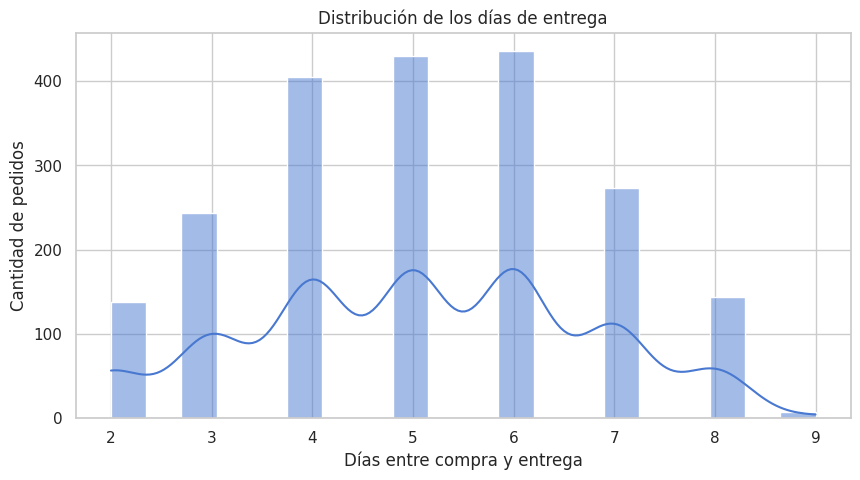

In [4]:
sns.histplot(orders["delivery_time_days"], bins=20, kde=True)
plt.title("Distribución de los días de entrega")
plt.xlabel("Días entre compra y entrega")
plt.ylabel("Cantidad de pedidos")
plt.show()

La mayoría de los pedidos se concentran en un rango de días relativamente reducido. <br>
Se observan algunos valores altos que pueden corresponder a rutas largas, demoras logísticas o valores extremos propios del dataset sintético.

### Distribución del retraso
Se grafica la distribución del retraso para conocer la frecuencia de entregas en tiempo, anticipadas o tardías. <br>
Esta variable es clave para relacionar el comportamiento de las entregas y la satisfacción del cliente.

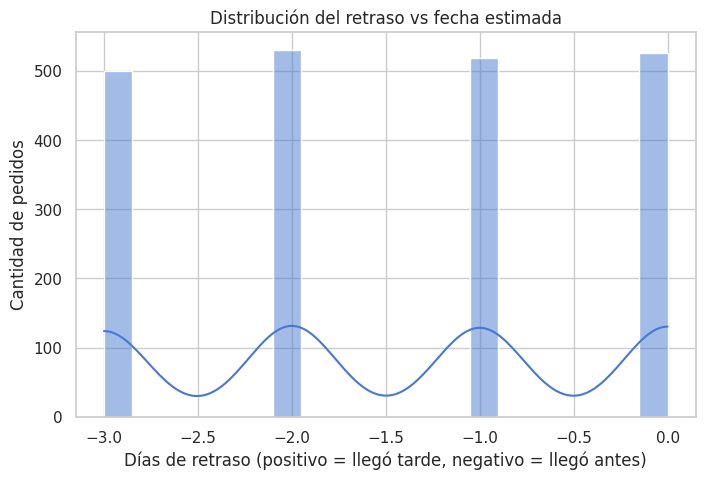

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(orders["delay_vs_estimate"], bins=20, kde=True)
plt.title("Distribución del retraso vs fecha estimada")
plt.xlabel("Días de retraso (positivo = llegó tarde, negativo = llegó antes)")
plt.ylabel("Cantidad de pedidos")
plt.show()

- Los valores cercanos a cero son los más comunes, indicando entregas dentro de lo esperado.
- Los valores positivos representan retrasos, mientras que los negativos indican entregas antes de lo estimado.


El histograma muestra que los valores de delay_vs_estimate están concentrados en pocos puntos específicos, lo que confirma que los datos sintéticos no siguen una distribución continua. La mayoría de los pedidos se agrupan en valores como 0, -1, -2 y -3 días, lo que indica entregas cercanas, o incluso anteriores, a la fecha estimada.
Esta concentración en bloques discretos refleja las reglas con las que se generó el dataset y no necesariamente un comportamiento real del mercado, pero aun así permite observar si existen tendencias generales de anticipos o retrasos.

### Calificaciones de los clientes

Se revisa la distribución de calificaciones asignadas por los clientes. <br>
Esto ayuda a identificar si predominan experiencias positivas, neutras o negativas.

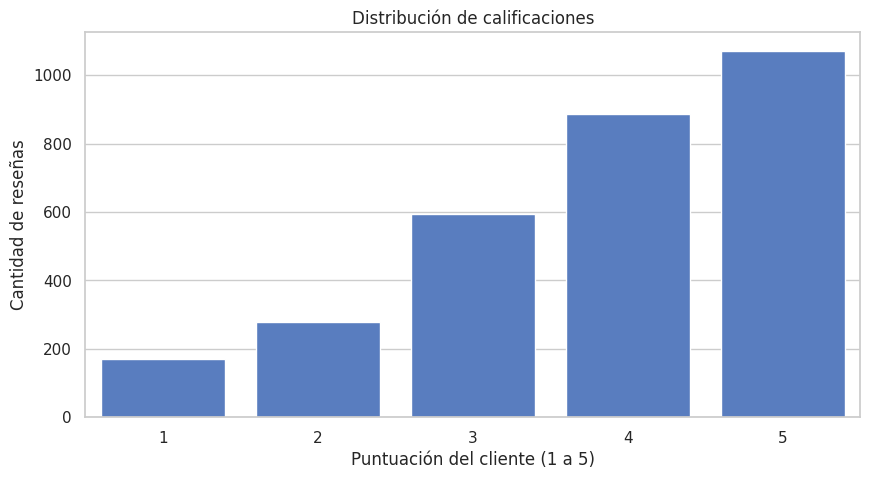

In [6]:
sns.countplot(x="review_score", data=orders, order=sorted(orders["review_score"].unique()))
plt.title("Distribución de calificaciones")
plt.xlabel("Puntuación del cliente (1 a 5)")
plt.ylabel("Cantidad de reseñas")
plt.show()


- El dataset muestra una tendencia hacia calificaciones altas, con lo que se puede inferir una satisfacción general positiva.
- Los valores bajos existen pero en menor proporción, por lo que pueden destacarse como casos relevantes en análisis posteriores.

### Análisis de variables numéricas
Los boxplots permiten visualizar valores extremos y el rango típico de cada variable. Esta vista complementa las distribuciones previas y ayuda a identificar posibles outliers.

### Valor total del pedido

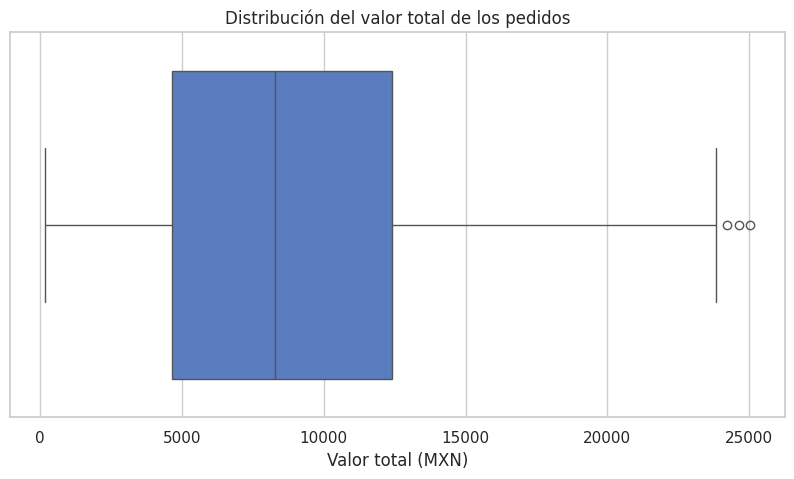

In [7]:
sns.boxplot(x=orders["order_total_value"])
plt.title("Distribución del valor total de los pedidos")
plt.xlabel("Valor total (MXN)")
plt.show()

El boxplot muestra que la mayoría de los pedidos se concentran en montos relativamente bajos, mientras que el valor total presenta una distribución sesgada hacia la derecha. La mayor parte de los pedidos cae dentro de un rango moderado, pero se observan algunos valores elevados que funcionan como outliers y representan compras significativamente más altas que el promedio. Esto es común en ecommerce, donde la mayoría de los clientes realiza compras pequeñas o medianas, mientras que unos pocos generan pedidos de ticket alto.

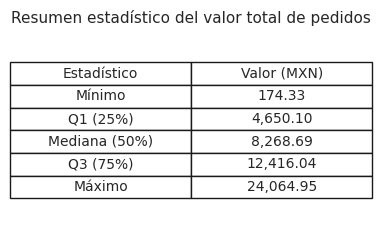

In [8]:
# Calcular estadísticas relevantes
stats = orders["order_total_value"].describe(percentiles=[.25, .5, .75])
iqr = stats["75%"] - stats["25%"]
lower_whisker = max(orders["order_total_value"].min(), stats["25%"] - 1.5 * iqr)
upper_whisker = min(orders["order_total_value"].max(), stats["75%"] + 1.5 * iqr)

# Crear DataFrame para mostrar los valores en tabla
summary_table = pd.DataFrame({
    "Estadístico": ["Mínimo", "Q1 (25%)", "Mediana (50%)", "Q3 (75%)", "Máximo"],
    "Valor (MXN)": [
        f"{lower_whisker:,.2f}",
        f"{stats['25%']:,.2f}",
        f"{stats['50%']:,.2f}",
        f"{stats['75%']:,.2f}",
        f"{upper_whisker:,.2f}"
    ]
})

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.axis("off")

tabla = ax.table(cellText=summary_table.values,
                 colLabels=summary_table.columns,
                 cellLoc='center',
                 loc='center')
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.4)

plt.title("Resumen estadístico del valor total de pedidos", fontsize=11, pad=10)
plt.tight_layout()
plt.show()

Los valores estadísticos muestran que el monto total de los pedidos presenta una gran variabilidad, con diferencias marcadas entre compras pequeñas y otras mucho más elevadas. <br>
El valor mínimo ronda los \$174, mientras que el máximo supera los \$24,000, lo que confirma la presencia de pedidos de alto valor dentro del conjunto. <br>
La mediana (~\$8,267) indica que la mitad de los pedidos se concentra por debajo de ese monto, y los cuartiles reflejan una dispersión amplia entre grupos de clientes. <br>
En conjunto, estas cifras ayudan a entender mejor el rango típico de los pedidos y a detectar valores que podrían representar comportamientos poco frecuentes o extremos.


## Análisis bivariado
### Relación entre retrasos y calificaciones

Aquí se explora si existe una relación entre el retraso en la entrega y la calificación del cliente.
Este es uno de los puntos clave para entender la experiencia del usuario dentro del proceso de logistica.

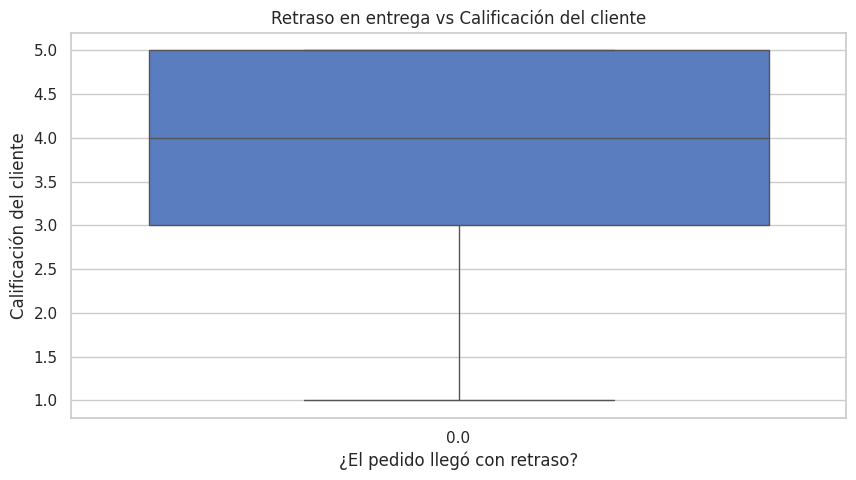

In [9]:
sns.boxplot(x="is_late", y="review_score", data=orders)
plt.title("Retraso en entrega vs Calificación del cliente")
plt.xlabel("¿El pedido llegó con retraso?")
plt.ylabel("Calificación del cliente")
plt.show()


El boxplot no muestra diferencias entre pedidos puntuales y retrasados porque toda la columna is_late toma el mismo valor. Por ello, el gráfico refleja solo la distribución general de review_score, sin permitir comparar grupos. Esto indica que no hay variabilidad en la variable de retraso dentro del dataset, o que la lógica para identificar retrasos no produjo valores distintos.

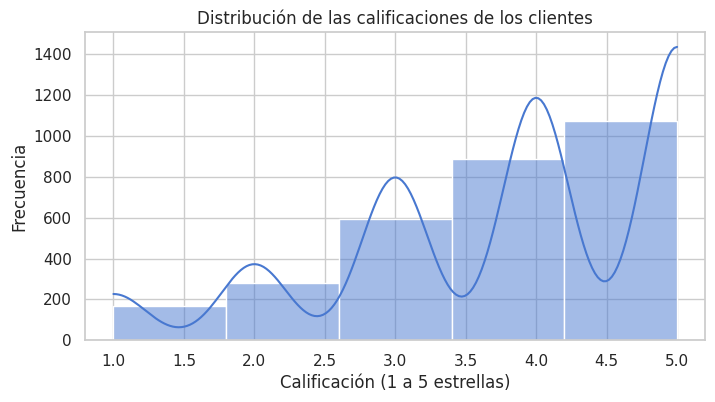

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(orders["review_score"], bins=5, kde=True)
plt.title("Distribución de las calificaciones de los clientes")
plt.xlabel("Calificación (1 a 5 estrellas)")
plt.ylabel("Frecuencia")
plt.show()

La distribución muestra que la mayoría de las calificaciones se concentran entre 4 y 5 estrellas, lo que sugiere que la experiencia general de los clientes tiende a ser positiva. Las calificaciones bajas (1 y 2 estrellas) aparecen en una proporción mucho menor, lo que indica que los casos de insatisfacción son menos frecuentes. En conjunto, la forma de la distribución refleja un comportamiento típico de ecommerce, donde la mayoría de los pedidos cumplen las expectativas del cliente y solo una minoría reporta experiencias negativas.

### Correlaciones numéricas
Se calcula y visualiza la matriz de correlaciones para identificar relaciones entre las variables numéricas principales del dataset.

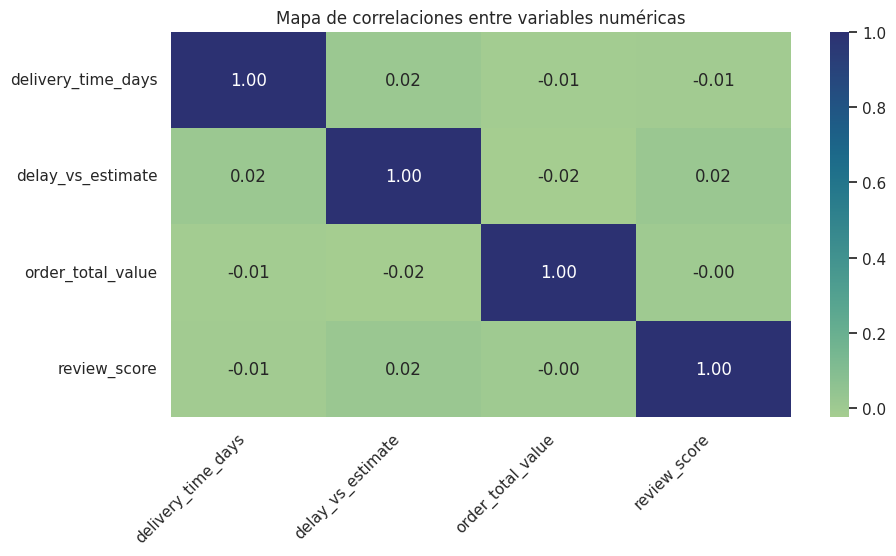

In [11]:
# columnas numéricas relevantes
num_cols = ["delivery_time_days", "delay_vs_estimate", "order_total_value", "review_score"]
corr = orders[num_cols].corr()

sns.heatmap(corr, annot=True, cmap=sns.color_palette("crest", as_cmap=True), fmt=".2f")
plt.title("Mapa de correlaciones entre variables numéricas")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


El mapa de correlaciones permite identificar si existe alguna relación lineal importante entre las variables numéricas analizadas. En este caso, los valores se mantienen muy cercanos a 0, lo que indica que ninguna variable presenta una correlación fuerte con otra.
- delivery_time_days vs delay_vs_estimate muestran una relación prácticamente nula.
- review_score tampoco presenta correlaciones significativas con los tiempos logísticos o el valor del pedido.
- order_total_value no está vinculado de manera relevante con retrasos ni con las calificaciones de los clientes.

En resumen, no se observan patrones lineales fuertes entre estas variables. Esto sugiere que los factores logísticos y el valor económico del pedido no están influyendo de forma directa en la calificación del cliente, al menos desde una perspectiva correlacional simple. <br>
Este resultado no descarta relaciones más complejas, pero sí indica que, a nivel general, el comportamiento del dataset es relativamente independiente entre estas dimensiones.

### Análisis por estado

El dataset de clientes contiene información adicional como el estado (customer_state) y la ciudad.
En este paso se integran esos datos con los pedidos para poder analizar el comportamiento de las entregas y las calificaciones por ubicación.

In [12]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,cus_3b0234601c0276e6cd4e08b6ae67,752285adda4ba605ecb5,31979,Vieja Guinea Bissau,Guanajuato
1,cus_24cb3fa4569c4fd058f954f2e6f9,be73f2b363bc7ff5041e,79036,Nueva China,Tabasco
2,cus_67a2c2db5bd7dc2f06a8f9b40226,03011d201a9f55cbe51f,1637,Nueva Djibouti,Morelos
3,cus_2b70a9c550bfd5e065a756e9fe9b,91b3ba99d751f32ea78e,75789,Nueva República de Corea,Guerrero
4,cus_36ba5c7d572c22a6650f11e37f4d,bbc95f29cf24fab977e1,6258,Vieja España,Baja California Sur


En esta sección se revisa la información geográfica del dataset de clientes, principalmente el estado y la ciudad, para confirmar que estas columnas están disponibles y listas para usarse en los análisis posteriores. La vista preliminar permite verificar la estructura del archivo y asegurarse de que los identificadores (customer_id, customer_unique_id) y datos de ubicación están completos.

Con esta información será posible, más adelante, relacionar los pedidos con la ubicación del cliente y explorar diferencias entre estados en temas como tiempos de entrega, retrasos o calificaciones. Esta revisión inicial solo valida que contamos con los datos necesarios para ese análisis regional.

In [13]:
# Unión de pedidos con la información de clientes
df = orders.merge(customers[["customer_id", "customer_state"]], on="customer_id", how="left")

In [14]:
df.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delay_vs_estimate,is_late,purchase_day,purchase_month,week_of_year,order_total_value,review_score,customer_state
0,ord_7370c26ead3d3cc6cee4f0548b8d,cus_3b0234601c0276e6cd4e08b6ae67,shipped,2025-08-16 21:12:27.948040,2025-08-16 23:12:27.948040,2025-08-17 23:12:27.948040,NaN,2025-08-24 23:12:27.948040,NaN,NaN,NaN,Saturday,August,33,4949.98,3,Guanajuato
1,ord_079072dd7970d40a3922a6b0c459,cus_24cb3fa4569c4fd058f954f2e6f9,delivered,2024-12-12 02:52:21.349382,2024-12-12 05:52:21.349382,2024-12-14 05:52:21.349382,2024-12-15 05:52:21.349382,2024-12-15 05:52:21.349382,3.0,0.0,0.0,Thursday,December,50,1276.09,4,Tabasco


In [15]:
# Confirmar incorporación de la nueva columna
df[["order_id", "customer_id","customer_state"]].head()

,order_id,customer_id,customer_state
0,ord_7370c26ead3d3cc6cee4f0548b8d,cus_3b0234601c0276e6cd4e08b6ae67,Guanajuato
1,ord_079072dd7970d40a3922a6b0c459,cus_24cb3fa4569c4fd058f954f2e6f9,Tabasco
2,ord_2600b1cb6f6a38610007a8c9142c,cus_67a2c2db5bd7dc2f06a8f9b40226,Morelos
3,ord_aaa7c4626ea7ea636e5bba7afebd,cus_2b70a9c550bfd5e065a756e9fe9b,Guerrero
4,ord_0ca0641b834ceb0a46f85637e125,cus_36ba5c7d572c22a6650f11e37f4d,Baja California Sur


Se realiza la unión usando la columna customer_id como clave.
El tipo de unión left join garantiza que se mantengan todos los registros de pedidos, incluso si algún cliente no tiene información geográfica asociada.

In [16]:
avg_state = df.groupby("customer_state")[["delivery_time_days", "review_score"]].mean().round(2)
avg_state.sort_values(by="delivery_time_days", ascending=False).head(10)


,delivery_time_days,review_score
customer_state,,
México,5.48,3.65
Puebla,5.46,3.84
Tlaxcala,5.40,3.83
Sinaloa,5.37,3.89
Yucatán,5.36,3.95
Baja California Sur,5.33,3.79
Oaxaca,5.27,3.82
Tabasco,5.25,3.84
Aguascalientes,5.23,3.86


Se confirmó que el dataset enriquecido está correctamente estructurado, con tipos de datos, columnas derivadas y valores esperados listos para el análisis.

Tiempos de entrega (delivery_time_days)
- La mayoría de los pedidos se concentra en un rango de entrega reducido.
- La variabilidad es moderada, lo que sugiere un comportamiento logístico estable dentro del dataset.

Retraso respecto a la fecha estimada (delay_vs_estimate)                                                            
- Los valores están agrupados en pocos días específicos (0, –1, –2, –3).
- Esta concentración discreta refleja la naturaleza sintética del dataset.
- A pesar de ello, se observa que la mayoría de las entregas ocurre en tiempo o antes de lo estimado.

Calificaciones de los clientes (review_score)
- Predominan las evaluaciones positivas: la mayoría son 4 y 5 estrellas.
- Las calificaciones bajas existen, pero en menor proporción, lo que indica una experiencia de usuario mayoritariamente favorable.

Valor total del pedido (order_total_value)
- Presenta una alta dispersión: desde compras pequeñas hasta pedidos de ticket elevado.
- La mediana (~$8,267 MXN) sugiere que un gran número de pedidos se mantiene en un rango medio.
- Se detectan outliers coherentes con compras inusualmente grandes.

Correlación entre variables numéricas
- No se identificaron relaciones lineales fuertes entre tiempos de entrega, retrasos, valor del pedido y calificación.
- Esto sugiere que, en este dataset, estas dimensiones se comportan de forma independiente entre sí.
- No descarta relaciones más complejas, pero aclara que no hay dependencias directas evidentes.

Integración de datos geográficos (customer_state)
- Se incorporó la información de ubicación del cliente mediante un merge con el dataset de customers.
- Esta unión permite avanzar hacia comparaciones regionales en notebooks posteriores.

En conjunto, el EDA permite:
- Validar que la preparación previa de datos fue correcta.
- Comprender el comportamiento general del ecommerce simulado.
- Identificar patrones relevantes para los análisis siguientes.
- Dejar listo el dataset para los estudios sobre relación entre desempeño logístico y satisfacción del cliente.

### Exportación del dataset enriquecido (que se ha modificado)

En la ejecución original del proyecto, el dataset enriquecido generado en este notebook fue almacenado como un archivo CSV para su reutilización en análisis posteriores.

Este archivo ya se encuentra versionado en el repositorio de GitHub dentro de la carpeta `data/processed`, por lo que el siguiente bloque de código se conserva únicamente como referencia del proceso realizado.

In [17]:
#output_path = "/content/drive/MyDrive/ecommerce_project/data/processed/orders_enriched.csv"
#df.to_csv(output_path, index=False)

#print(f"Archivo guardado correctamente en: {output_path}")
